In [0]:
!pip install mctspy

In [0]:
import matplotlib.pyplot as plt
#!/usr/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
 
import threading
import time
import random
import numpy as np
from tree.nodes import TwoPlayersGameMonteCarloTreeSearchNode
from tree.search import MonteCarloTreeSearch
from mctspy.games.examples.tictactoe import TicTacToeGameState, TicTacToeMove

In [0]:

##############################################################################
# Mise en place de la grille du jeu
imax = 3
jmax = 3
grille=[] 
for i in range(0,imax):
    grille.append([])
    for j in range(0,jmax):
        grille[i].append(' ')
 
###############################################################################
def initcoef():
    """créer un tableau  de coefficients: 1.0 pour les cases vides, 0.0 sinon"""
    global grille,imax,jmax
    coef=[]
    for i in range(0,imax):
        coef.append([])
        for j in range(0,jmax):
            if grille[i][j]==' ':
                coef[i].append(1.0)
            else:
                coef[i].append(0.0)
    return coef
 
###############################################################################
def pondcoef(coef):
    """pondère les cases vides en fonction de leurs positions"""
    coef[1][1]*=3.0
    coef[0][0]*=2.0
    coef[2][2]*=2.0
    coef[0][2]*=2.0
    coef[2][0]*=2.0
    return coef
 
###############################################################################
def coupscoef(coef):
    global grille, imax, jmax
 
    # obtenir la liste des coups possibles par ordre décroissant des coef
    L=[]
    for i in range(0,imax):
        for j in range(0,jmax):
            if coef[i][j]>0:
                L.append([coef[i][j], i, j])
    L.sort()
    L.reverse()
 
    # si plusieurs cases avec coef le + fort, sélectionner le 1er au hasard
    if len(L)!=0:
        c=L[0][0]
        im=0
        for i in range(1,len(L)):
            if L[i][0]!=c:
                im=i-1
                break
        k=random.randint(0,im)
        x=L.pop(k)
        L.insert(0,x)
 
    # renvoyer une liste ordonnee (coef décroissants) sans les coef
    R=[]
    for i,j,k in L:
        R.append([j,k])
    return R
 
###############################################################################
def coupsgagnants(pion):
    global grille
    L=[]
    p1=pion + pion + " "
    p2=pion + " " + pion
    p3=" " + pion + pion
    # 1ère ligne
    x = "".join(grille[0])
    if x==p1: L.append([0,2]) 
    if x==p2: L.append([0,1]) 
    if x==p3: L.append([0,0]) 
 
    # 2ème ligne
    x = "".join(grille[1])
    if x==p1: L.append([1,2]) 
    if x==p2: L.append([1,1]) 
    if x==p3: L.append([1,0]) 
 
    # 3ère ligne
    x = "".join(grille[2])
    if x==p1: L.append([2,2]) 
    if x==p2: L.append([2,1]) 
    if x==p3: L.append([2,0]) 
 
    z=[grille[0],grille[1],grille[2]]
    # 1ère colonne
    x = "".join(z[0])
    if x==p1: L.append([2,0]) 
    if x==p2: L.append([1,0]) 
    if x==p3: L.append([0,0]) 
 
    # 2ème colonne
    x = "".join(z[1])
    if x==p1: L.append([2,1]) 
    if x==p2: L.append([1,1]) 
    if x==p3: L.append([0,1]) 
 
    # 3ème colonne
    x = "".join(z[2])
    if x==p1: L.append([2,2]) 
    if x==p2: L.append([1,2]) 
    if x==p3: L.append([0,2]) 
 
     # 1ère diagonale
    x = grille[0][0] + grille[1][1] + grille[2][2]
    if x==p1: L.append([2,2]) 
    if x==p2: L.append([1,1]) 
    if x==p3: L.append([0,0]) 
 
     # 2ème diagonale
    x = grille[0][2] + grille[1][1] + grille[2][0]
    if x==p1: L.append([2,0]) 
    if x==p2: L.append([1,1]) 
    if x==p3: L.append([0,2]) 
 
    return L
 #############################################################################
def tranformation(pion):
        '''
        transformation de la grille en tableau avec des 1 pour le MCTS joueur
        et des -1 pour le computer 
        '''
        global grille
        b=grille.copy()
        c=[]
        for i in range(len(b)):
          for j in range(len(b[0])):
            if b[i][j]==' ':
              c.append(0)
            elif  b[i][j]=='X':
              c.append(1)
            else :
              c.append(-1)
        return np.array(c).reshape(3,3) #reshape in a two day array

##############################################################################
def best_move_mcts(pion, simu,c_param):
        '''
        meilleur mouvement selon le MCTS
        Parameters : 
        - pion : 'X' ou 'O'
        - simu : nombre de simulation pour le MCTS algorithm
        - c_param : valeur du c_param
        '''
        state = tranformation(pion) #Transformation de la grille en grille adapté pour la librairie
        initial_board_state = TicTacToeGameState(state = state, next_to_move=1) #MCTS correspond toujours au jours 2 (qui joue des 'X'-> 1)
        root = TwoPlayersGameMonteCarloTreeSearchNode(state = initial_board_state) #
        
        #perform mcts 
        mcts = MonteCarloTreeSearch(root)
        new_state = mcts.best_action(simu, c_param=c_param).state.board #Donne un tableau avec le nouveau mouvement
        n_st=new_state-state #mouvement joué par MCTS
        new_move= np.argwhere(n_st == 1)[0] # corrdonnée du mouvement
        return new_move



###############################################################################
def correction(LC,pionautre):
    """parmi les coups de la liste LC, mettre en avant un coup plus efficace s'il y en a un"""
    if len(LC)<=1:
        return LC
    kc=0
    for k in range(0,len(LC)):
        ic=LC[k][0]
        jc=LC[k][1]
 
        # vérif ligne ic
        ch=grille[ic][0] + grille[ic][1] + grille[ic][2]
        if ch.find(pionautre)<0:
            # => la ligne ic n'a pas le pion de l'adversaire
            kc=k
            break
 
        # vérif colonne jc
        ch=grille[0][jc] + grille[1][jc] + grille[2][jc]
        if ch.find(pionautre)<0:
            # => la colonne jc n'a pas le pion de l'adversaire
            kc=k
            break
 
        # vérif 1ère diagonale si la case ic,jc en fait partie
        if ic==jc:
            ch=grille[0][0] + grille[1][1] + grille[2][2]
            if ch.find(pionautre)<0:
                # => la 1ère diagonale n'a pas le pion de l'adversaire
                kc=k
                break
 
        # vérif 2ème diagonale si la case ic,jc en fait partie
        if ic==(2-jc):
            ch=grille[0][2] + grille[1][1] + grille[2][0]
            if ch.find(pionautre)<0:
                # => la 2ème diagonale n'a pas le pion de l'adversaire
                kc=k
                break
 
    if kc>0:
        # on a trouvé un meilleur coup que le 1er: le mettre en 1ère position
        L=LC.pop(kc)
        LC.insert(0,L)
 
    return LC
 
###############################################################################
def ajouer(pion): 
    # recherche de qui est en train de jouer
    if pion=='X':
        pionautre='O'
    else:
        pionautre='X'
 
    # recherche des positions gagnantes s'il y en a
    LG = coupsgagnants(pion)
 
    # recherche des positions perdantes (=gagnantes pour l'autre!) s'il y en a
    LP = coupsgagnants(pionautre)
    # recherche des positions recommandees avec les coefficients
    # initialise le tableau des coefficients
    c=initcoef()
    # ajoute les pondérations des cases
    c=pondcoef(c)
    # sélectionne tous les coups possibles dans l'ordre décroissant des coefficients
    LC=coupscoef(c)
 
    # met au début de cette liste, si possible, un coup efficace
    LC=correction(LC,pionautre)   
    # restituer le meilleur coup
    if len(LG)!=0:
        return LG[0]
 
    if len(LP)!=0:
        return LP[0]
 
    return LC[0]
 
###############################################################################
def grillepleine():
    global grille,imax,jmax
    for i in range(0,imax):
        for j in range(0,jmax):
            if grille[i][j]==' ':
                return False
    return True
 
###############################################################################
def jeugagne():
 
    def _jeugagne(pion):
        global grille
        x = pion + pion + pion
        if \
        "".join(grille[0])==x or \
        "".join(grille[1])==x or \
        "".join(grille[2])==x or \
        grille[0][0]+grille[1][0]+grille[2][0]==x or \
        grille[0][1]+grille[1][1]+grille[2][1]==x or \
        grille[0][2]+grille[1][2]+grille[2][2]==x or \
        grille[0][0]+grille[1][1]+grille[2][2]==x or \
        grille[0][2]+grille[1][1]+grille[2][0]==x:
            return True
        else:
            return False
 
    if _jeugagne('X'):
        return 'X'
    if _jeugagne('O'):
        return 'O'
    return ''

### Alpha beta algorithm

In [0]:
def max_alpha_beta(alpha, beta):
          maxv = -2
          px = None
          py = None
          b=grille.copy()

          for i in range(len(grille)):
              for j in range(len(grille[0])):
                  if grille[i][j] == ' ':
                      grille[i][j] = 'O'
                      (m, min_i, in_j) = min_alpha_beta(alpha, beta)
                      if m > maxv:
                          maxv = m
                          px = i
                          py = j
                      grille[i][j] = ' '

                      # Next two ifs in Max and Min are the only difference between regular algorithm and minimax
                      if maxv >= beta:
                          return (maxv, px, py) # fail hard beta-cutoff

                      if maxv > alpha:
                          alpha = maxv # alpha acts like max in MiniMax

          return (maxv, px, py)

def min_alpha_beta(alpha, beta):

        minv = 2

        qx = None
        qy = None

        for i in range(0, 3):
            for j in range(0, 3):
                if grille[i][j] == ' ':
                    grille[i][j] = 'X'
                    (m, max_i, max_j) = max_alpha_beta(alpha, beta)
                    if m < minv:
                        minv = m
                        qx = i
                        qy = j
                    grille[i][j] = ' '

                    if minv <= alpha:
                        return (minv, qx, qy) # fail hard alpha-cutoff

                    if minv < beta:
                        beta = minv # beta acts like min in MiniMax

        return (minv, qx, qy)

### Class principal Joueur

In [0]:
class Joueur(threading.Thread):
 
    def __init__(self, nom, num, pion, typejoueur,simu,c_param):
        threading.Thread.__init__(self)
        self.setName(nom)  # nom du joueur. Ex: "joueur1", "joueur2", ...
        self.num = num  # numéro du joueur. Ex: 0 pour joueur1, 1 pour joueur2, etc...
        self.pion = pion  # forme de pion affecté
        self.typejoueur = typejoueur  # type de joueur: 0 = ordinateur, 1 = humain
        self.stop = False  # drapeau pour stopper le thread à la demande du programme principal
        self.simu=simu
        self.c_param=c_param
 
    def run(self):
        # accès aux variables globales
        global verrou # verrou d'accès aux variables globales
        global okjoue  # drapeau donnée par le programme principal qui permet au joueur de jouer
        global cdcoups  # compteur de coups
        global premier  # désigne le numéro du joueur qui a joué en premier
        global nbjoueurs  # nombre de joueurs du jeu

 
        while not self.stop:  # tant que le jeu n'est pas terminé
 
            ##### => chaque joueur attend son tour pour jouer
            while True:
                # on prend le verrou d'accès aux variables globales
                verrou.acquire()
                if self.stop:
                    # jeu terminé. on sort de la boucle, mais en conservant le blocage du verrou
                    break
                if okjoue and (cdcoups+premier)%nbjoueurs==self.num:
                    # = ça y est, on peut jouer, mais on conserve le verrou jusqu'à la fin du coup
                    break
                # on libère le verrou pour que les autres joueurs accédent aussi aux variables globales
                verrou.release()
 
            ##### => le joueur en cours joue
 
            if not self.stop:
                if self.typejoueur==0:
                    # c'est un joueur "ordinateur" qui joue
                    if self.pion=='X':
                        pionautre='O'
                    else:
                        pionautre='X'
                    print
                    print (self.getName() + " joue ('" + self.pion + "' contre '" + pionautre + "')")
                    self.chx = ajouer(self.pion)
                    print (self.getName() + " joue case: ",self.chx)
                    grille[self.chx[0]][self.chx[1]]=self.pion
                    time.sleep(0.1)
                elif self.typejoueur==3:
                  # c'est un joueur "Monte Carlos Tree Search"
                    if self.pion=='X':
                         pionautre='O'
                    else:
                         pionautre='X'
                    print
                    #print (self.getName() + " joue ('" + self.pion + "' contre '" + pionautre + "')")
                    self.chx = best_move_mcts(self.pion, self.simu, self.c_param)
                    
                    print (self.getName() + " joue case: ",self.chx)
                    grille[self.chx[0]][self.chx[1]]=self.pion
                    time.sleep(0.1) 
                       
                elif self.typejoueur==4:
                  # c'est un joueur Alpha Beta
                    if self.pion=='X':
                         pionautre='O'
                    else:
                         pionautre='X'
                    print
                    start = time.time()
                    (m, qx, qy) = min_alpha_beta(-2, 2)
                    end = time.time()
                    if (qx==None and qy== None): #Si il n'arrive pas à trouver la position 
                      qx=random.randint(0,2)
                      qy=random.randint(0,2)
                    
                    grille[qx][qy]=self.pion
                    self.chx=[qx,qy]
                    print (self.getName() + " joue case: ",self.chx)
                    time.sleep(0.1)                   

                #else:
                    # c'est un joueur "humain" qui joue
                    #if self.pion=='X':
                     #   pionautre='O'
                    #else:
                      #  pionautre='X'
                    #print
                    #print (self.getName() + " joue ('" + self.pion + "' contre '" + pionautre + "')")
                    #self.chx = ajouer(self.pion)
                    #ch=self.getName() + " joue case: "
                    #ch = self.getName() + " joue case (ligne,colonne):"
                    #while True:
                        #self.coup = input(ch)
                        #try:
                            # ici, le joueur a entré un choix ligne,colonne
                           # x = eval(self.coup)
                           # if ((type(x)==list or type(x)==tuple) and len(x)==2) \
                            #        and (x[0] in [0,1,2]) and (x[1] in [0,1,2]) \
                             #           and grille[x[0]][x[1]]==' ':
                              #  grille[x[0]][x[1]]=self.pion
                              #  break
                        #except:
                            # ici, le choix entré n'est pas correct
                            # pass
 
            ##### => fin du coup du joueur en cours
 
            # le joueur repasse la main au programme principal après chaque coup
            okjoue = False
 
            # on libère le verrou d'accès aux variables globales
            verrou.release()
 
            # et fin du thread si c'est demandé (sinon, attente du prochain coup)
            if self.stop:
                break
 
    def stopper(self):
        self.stop = True

##############################################################################
# Mise en place de la grille du jeu
imax = 3
jmax = 3
grille=[] 
for i in range(0,imax):
    grille.append([])
    for j in range(0,jmax):
        grille[i].append(' ')
 
############################## => initialisation du jeu et des conditions de son démarrage
 
# nombre de joueurs
nbjoueurs = 2

simu=4000
c_param=1.
 
# type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
while True:
    print
    print ("Type de joueurs:")
    print ("[1]: Alpha beta vs Alpha zero")
    print ("[2]: Oridnateur vs Alpha zero")
    x = input("Quel choix voulez-vous? [2 par defaut]: ")
    if x=='1' or x=='':
        typejoueurs=[4,3]
        break
    if x=='2':
        typejoueurs=[0,3]
        break
    
 
 
# type de pion affecté à chaque joueur.
pions = ['O','X']  # 
print
print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")
 
# définir celui qui commence, ou définir au hasard
premier = random.randint(0,nbjoueurs-1)
 
############################## => initialisation du programme
 
# création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
verrou = threading.Lock()

# création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
cdcoups = -1
 
# drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
#   (initialisé à -1 parce que c'est le programme principal qui commence)
okjoue = False

# creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
joueurs = []
for i in range(0,nbjoueurs):
    j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],simu, c_param=c_param)
    j.setDaemon(True)
    joueurs.append(j)
 
# lancement de tous les threads des joueurs
for i in range(0,nbjoueurs):
    joueurs[i].start()
 
##############################
# surveillance du jeu et attente condition de fin de partie
tps=time.time()
while True:
    # attente qu'un joueur ait joué
    while True:
        verrou.acquire()
        if not okjoue:
            cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
            # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
            break
        verrou.release()
 
    # affichage de la grille après le dernier coup
    print
    for i in range(0,imax):
        print(grille[i])
 
 
    # voir si un gagnant
    x = jeugagne()
    if x!="":
          if x==pions[0]:
            if x=='1' :
              gagnant = "Alpha Beta ('" + pions[0] + "')"
            else :
              gagnant = "Ordinateur ('" + pions[0] + "')"
          else:
              gagnant = "Alpha Zero ('" + pions[1] + "')"
          print
          print ("le gagnant est: " + gagnant)
          verrou.release()
          break
 
    # condition de fin de jeu
    if grillepleine():
        print
        print("pas de gagnant!")
        verrou.release()
        break
 
    # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
    ch=""
    if cdcoups%nbjoueurs==0:
        print
        print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))
 
    # permet au joueur suivant de jouer
    okjoue = True
    verrou.release()
    # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué
 
#############################
# fin du jeu
print
print ("fin du jeu")
 
# arrêt de tous les threads
for i in range(0,nbjoueurs):
    joueurs[i].stopper()
 
# attente jusqu'à ce que tous les threads soient terminés
for i in range(0,nbjoueurs):
    joueurs[i].join()
    verrou.acquire()
    #print ("fin du thread " + joueurs[i].getName())
    verrou.release()
 
print
print ("A bientôt pour un prochain jeu!")

Type de joueurs:
[1]: Alpha beta vs Alpha zero
[2]: Oridnateur vs Alpha zero
Quel choix voulez-vous? [2 par defaut]: 2
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 1]
[' ', ' ', ' ']joueur1 joue ('O' contre 'X')

[' ', 'X', ' ']joueur1 joue case: 
 [' ', ' ', ' '][2, 2]

[' ', ' ', ' ']
[' ', 'X', ' ']
[' ', ' ', 'O']
=====> début du tour 2
joueur2 joue case:  [1 2]
[' ', ' ', ' ']joueur1 joue ('O' contre 'X')
[' ', 'X', 'X']
[' ', ' ', 'O']

joueur1 joue case:  [1, 0]
[' ', ' ', ' ']
['O', 'X', 'X']
[' ', ' ', 'O']
=====> début du tour 3
joueur2 joue case:  [2 0]
[' ', ' ', ' ']joueur1 joue ('O' contre 'X')

['O', 'X', 'X']joueur1 joue case: 
 ['X', ' ', 'O'][0, 2]

[' ', ' ', 'O']
['O', 'X', 'X']
joueur2 joue case: ['X', ' ', 'O']
=====> début du tour 4
 [0 1]
[' ', 'X', 'O']joueur1 joue ('O' contre 'X')

['O', 'X', 'X']joueur1 joue case: 
 ['X', ' ', 'O'][0, 0]

['O', 'X', 'O']jo

### Influence Nombre de simulation 

In [0]:
nbre_simu=10 #nombre de parties pour chaque nombre de simulation
simu=[100, 500, 1000, 3000, 5000] #Nbre simulation pour MCTS


#### Alpha Beta vs Monte Carlo Tree Search

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:  
  print ("Nombre de simulations :", sim)
  compteur=0
  
  while compteur <nbre_simu:
    
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')

    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 3= Monte Carlo Tree Search, 4= Alpha Beta; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[4,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = random.randint(0,nbjoueurs-1)
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False
    c_param=1.
    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 0]
[' ', ' ', ' ']joueur1 joue case: 
 ['X', ' ', ' '][2, 2]

[' ', ' ', ' ']
[' ', ' ', ' ']
['X', ' ', ' ']
[' ', ' ', 'O']
=====> début du tour 2
joueur2 joue case:  [2 0]
[' ', ' ', ' ']joueur1 joue case: 
['X', ' ', ' ']
['X', ' ', 'O']
 [2, 0]
[' ', ' ', ' ']joueur2 joue case: 
['X', ' ', ' ']
['O', ' ', 'O']
=====> début du tour 3
 [2 1]
[' ', ' ', ' ']
['X', ' ', ' ']
['O', 'X', 'O']
joueur1 joue case:  [0, 0]
['O', ' ', ' ']
['X', ' ', ' ']
['O', 'X', 'O']
=====> début du tour 4
joueur2 joue case:  [1 1]
['O', ' ', ' ']joueur1 joue case: 
['X', 'X', ' ']
['O', 'X', 'O']
 [0, 1]
['O', 'O', ' ']
['X', 'X', ' ']
['O', 'X', 'O']
=====> début du tour 5
joueur2 joue case:  [1 2]
['O', 'O', ' ']
['X', 'X', 'X']
['O', 'X', 'O'

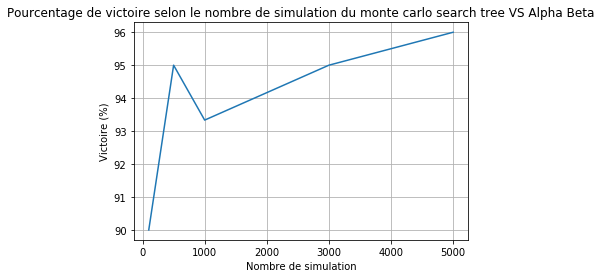

In [0]:
plt.plot(simu,victory_rate)
plt.title("Pourcentage de victoire selon le nombre de simulation du monte carlo search tree VS Alpha Beta")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

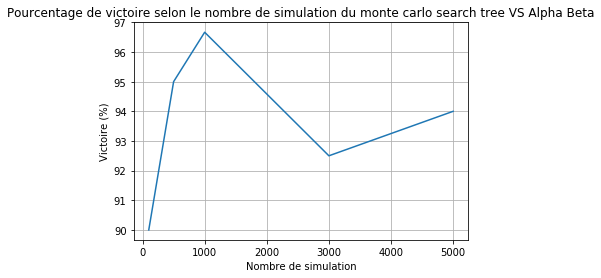

In [0]:
plt.plot(simu,victory_rate)
plt.title("Pourcentage de victoire selon le nombre de simulation du monte carlo search tree VS Alpha Beta")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

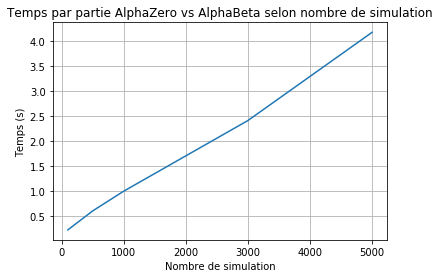

In [0]:
plt.plot(simu,temps_moyen)
plt.title("Temps par partie AlphaZero vs AlphaBeta selon nombre de simulation")
plt.xlabel("Nombre de simulation")
plt.ylabel("Temps (s)")
plt.grid()

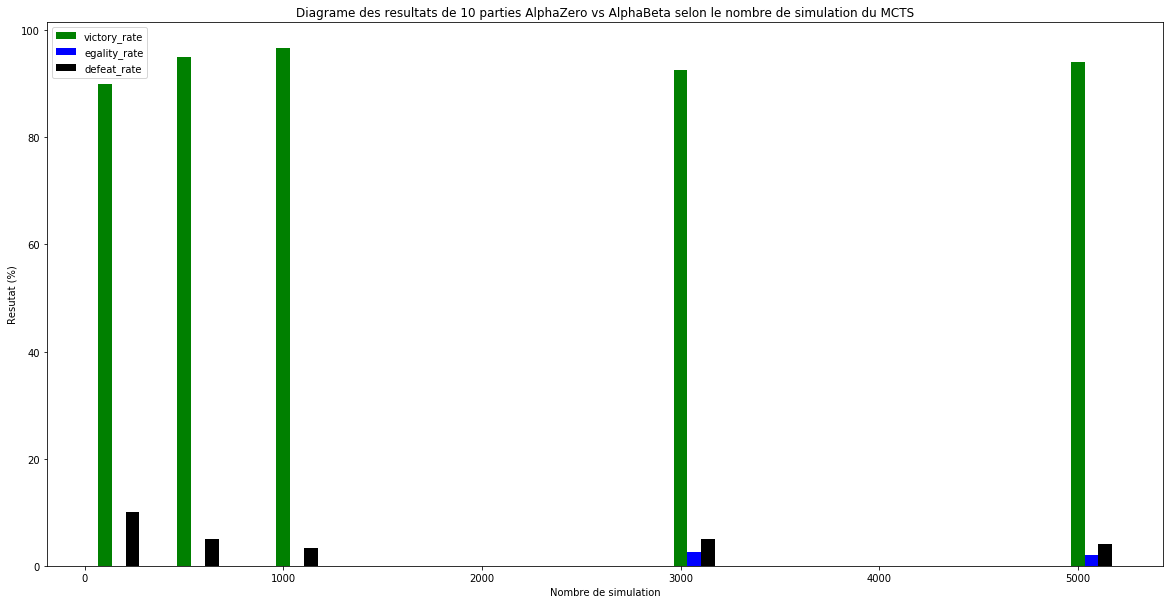

In [0]:
simu=[100, 500, 1000, 3000, 5000] #Nbre simulation pour MCTS

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

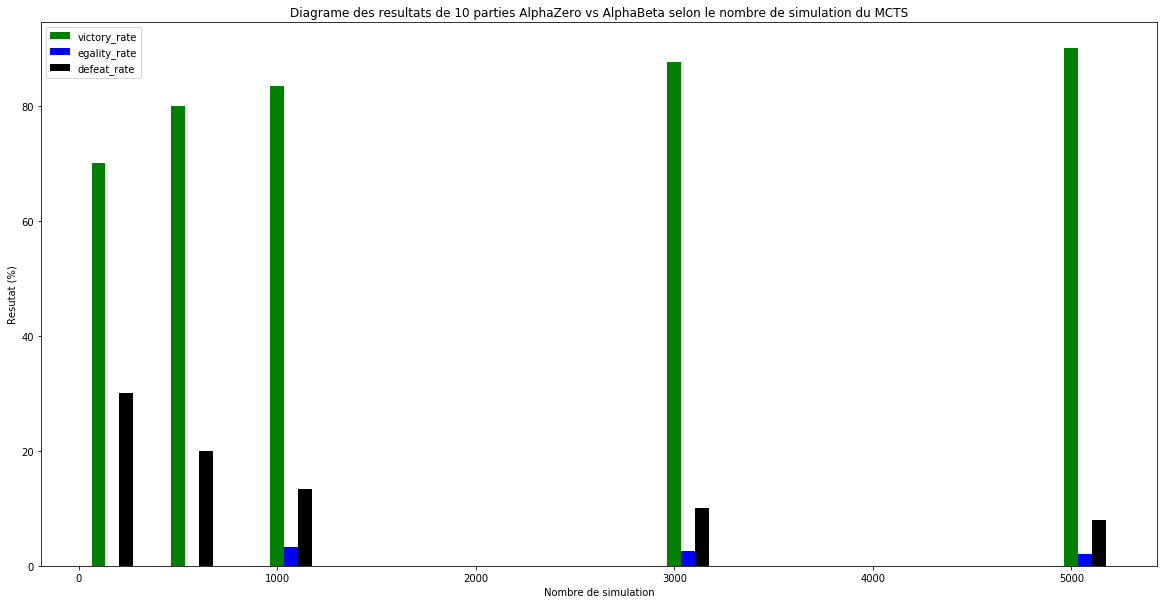

In [0]:
simu=[100, 500, 1000, 3000, 5000] #Nbre simulation pour MCTS

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

#### Ordinateur vs Monte Carlo Tree Search

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:
  print ("Nombre de simulations :", sim)
  compteur=0
  while compteur <nbre_simu:
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')
            
    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[0,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = random.randint(0,nbjoueurs-1)
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False

    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  #print(nb_victoire)
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 2]
[' ', ' ', ' ']
[' ', ' ', 'X']
[' ', ' ', ' ']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [1, 1]
[' ', ' ', ' ']
[' ', 'O', 'X']
[' ', ' ', ' ']
=====> début du tour 2
joueur2 joue case:  [2 1]
[' ', ' ', ' ']
[' ', 'O', 'X']
[' ', 'X', ' ']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [2, 0]
[' ', ' ', ' ']
[' ', 'O', 'X']
['O', 'X', ' ']
=====> début du tour 3
joueur2 joue case:  [0 2]
[' ', ' ', 'X']
[' ', 'O', 'X']
joueur1 joue ('O' contre 'X')['O', 'X', ' ']

joueur1 joue case:  [2, 2]
[' ', ' ', 'X']
[' ', 'O', 'X']
['O', 'X', 'O']
=====> début du tour 4
joueur2 joue case:  [0 0]
['X', ' ', 'X']
[' ', 'O', 'X']
['O', 'X', 'O']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [0, 1]
['X', 'O', 'X']
[' ', '

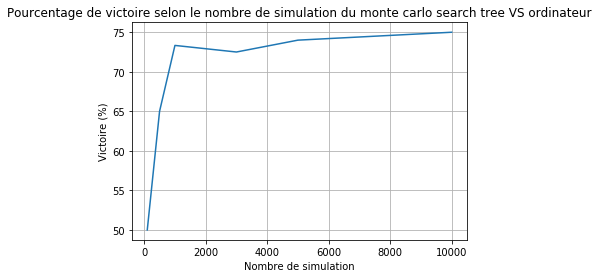

In [0]:
plt.plot(simu,victory_rate)
plt.title("Pourcentage de victoire selon le nombre de simulation du monte carlo search tree VS ordinateur")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

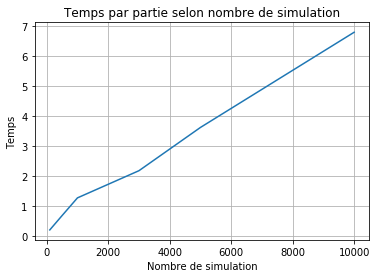

In [0]:
plt.plot(simu,temps_moyen)
plt.title("Temps par partie selon nombre de simulation")
plt.xlabel("Nombre de simulation")
plt.ylabel("Temps")
plt.grid()

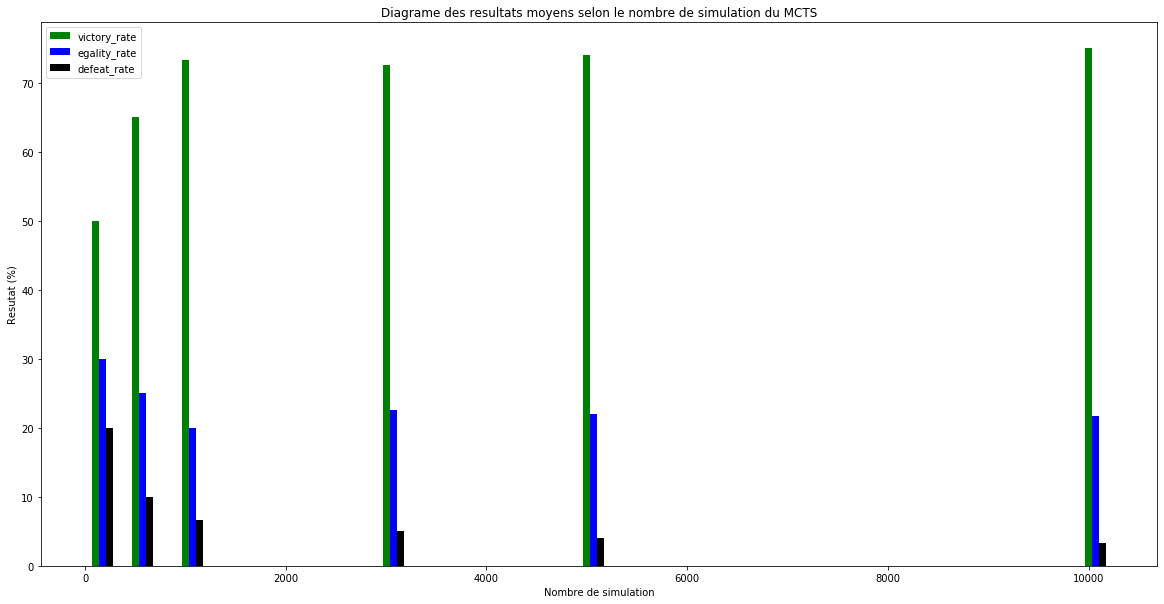

In [0]:
simu=[100, 500, 1000, 3000, 5000, 10000] #Nbre simulation pour MCTS

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats moyens selon le nombre de simulation du MCTS")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

### Influence c_param

In [0]:
c_param=[0.1, 0.25, 0.5, 0.75, 1, 1.5, 2] #Influence c_param

#### Alpha Beta vs Ordinateur

In [0]:

nb_victoire=[]
victory_rate=[]

egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for param in c_param:
  compteur=0
  while compteur <nbre_simu:
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')
            
    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[0,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = random.randint(0,nbjoueurs-1)
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False

    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],10,param)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire()
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur 1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur 2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  print(nb_victoire)
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  
  


Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [2 1]
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', 'X', ' ']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [1, 1]
[' ', ' ', ' ']joueur2 joue case:  
[2 0][' ', 'O', ' ']

[' ', 'X', ' ']
=====> début du tour 2
[' ', ' ', ' ']
[' ', 'O', ' ']
joueur1 joue ('O' contre 'X')['X', 'X', ' ']

joueur1 joue case:  [2, 2]
[' ', ' ', ' ']
[' ', 'O', ' ']
['X', 'X', 'O']
joueur2 joue case: =====> début du tour 3
 [1 2]
[' ', ' ', ' ']
[' ', 'O', 'X']
['X', 'X', 'O']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [0, 0]
['O', ' ', ' ']
[' ', 'O', 'X']
['X', 'X', 'O']
le gagnant est: joueur 1 ('O')
fin du jeu
fin du thread joueur1
fin du thread joueur2
A bientôt pour un prochain jeu!
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X

Text(0, 0.5, 'Victoire (%)')

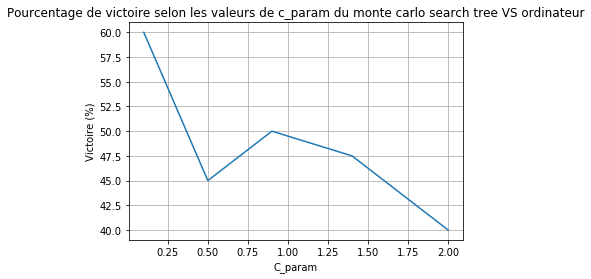

In [0]:
plt.plot(c_param,victory_rate)
plt.title("Pourcentage de victoire selon les valeurs de c_param du monte carlo search tree VS ordinateur")
plt.xlabel("C_param")
plt.grid()
plt.ylabel("Victoire (%)")

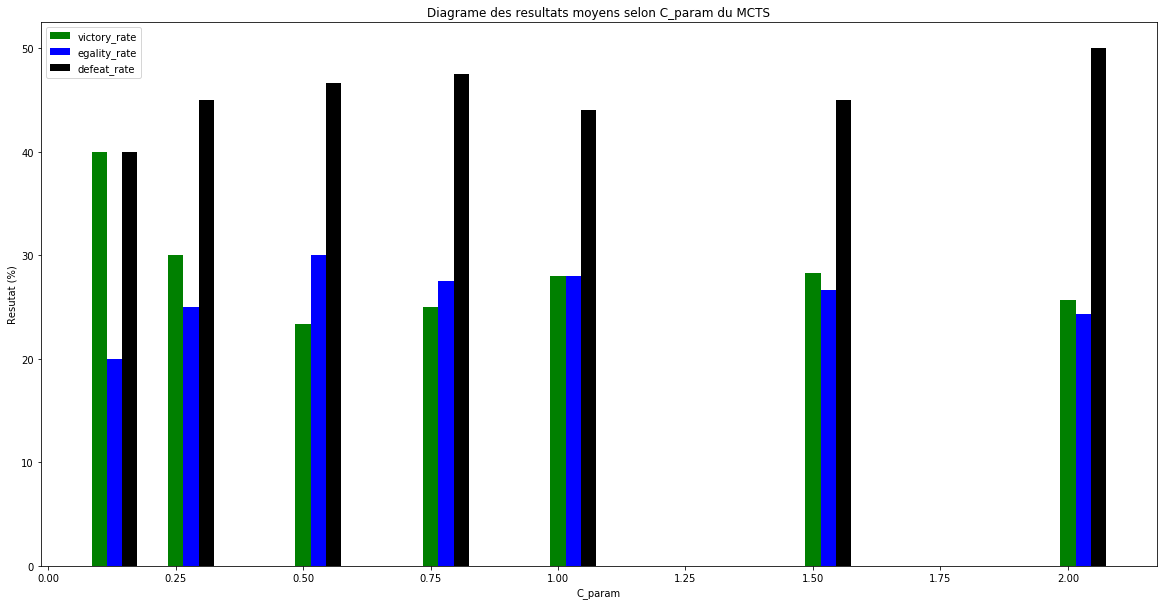

In [0]:
plt.figure(figsize=(20,10))

barWidth = 0.03
c_param2 = [x + barWidth for x in c_param]
c_param3 = [x + barWidth for x in c_param2]

plt.bar(c_param,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(c_param2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(c_param3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats moyens selon C_param du MCTS")
plt.xlabel("C_param")
plt.ylabel("Resutat (%)")
plt.legend()

#### AlphaBeta vs Monte Carlo Tree Search

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]

for param in c_param:
  compteur=0
  while compteur <nbre_simu:
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')
            
    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[4,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = random.randint(0,nbjoueurs-1)
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False

    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],10,param)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire()
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  
  


Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur1 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur1 joue case:  [0, 0]
['O', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
joueur2 joue case:  [2 0]
['O', ' ', ' ']
[' ', ' ', ' ']
['X', ' ', ' ']
=====> début du tour 2
joueur1 joue case:  [0, 1]
['O', 'O', ' ']
[' ', ' ', ' ']
['X', ' ', ' ']
joueur2 joue case:  [2 2]
['O', 'O', ' ']
[' ', ' ', ' ']
['X', ' ', 'X']
=====> début du tour 3
joueur1 joue case:  [0, 2]
['O', 'O', 'O']
[' ', ' ', ' ']
['X', ' ', 'X']
le gagnant est: joueur1 ('O')
fin du jeu
fin du thread joueur1
fin du thread joueur2
A bientôt pour un prochain jeu!
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 2]
[' ', ' ', ' ']
[' ', ' ', 'X']


Text(0, 0.5, 'Victoire (%)')

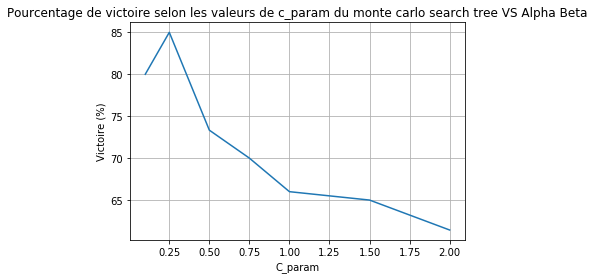

In [0]:
plt.plot(c_param,victory_rate)
plt.title("Pourcentage de victoire selon les valeurs de c_param du monte carlo search tree VS Alpha Beta")
plt.xlabel("C_param")
plt.grid()
plt.ylabel("Victoire (%)")

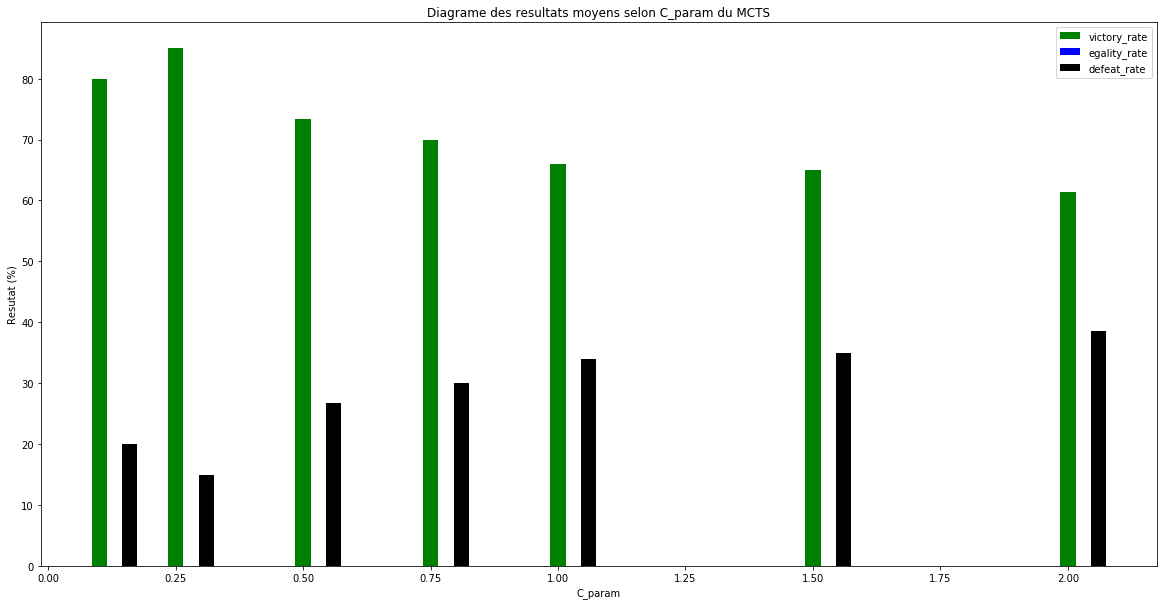

In [0]:
plt.figure(figsize=(20,10))

barWidth = 0.03
c_param2 = [x + barWidth for x in c_param]
c_param3 = [x + barWidth for x in c_param2]

plt.bar(c_param,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(c_param2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(c_param3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats moyens selon C_param du MCTS")
plt.xlabel("C_param")
plt.ylabel("Resutat (%)")
plt.legend()

## Influence de l'algorithme qui commence 

In [0]:
nbre_simu=10 #nombre de parties pour chaque nombre de simulation
simu=[100, 500, 1000, 3000, 5000] #Nbre simulation pour MCTS

### AlphaZero VS AlphaBeta

#### Influence lorsque AlphaZero commence

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:  
  print ("Nombre de simulations :", sim)
  compteur=0
  
  while compteur <nbre_simu:
    
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')

    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 3= Monte Carlo Tree Search, 4= Alpha Beta; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[4,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = 1
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False
    c_param=1.
    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 1]
[' ', ' ', ' ']
[' ', 'X', ' ']
[' ', ' ', ' ']
joueur1 joue case:  [0, 1]
[' ', 'O', ' ']
[' ', 'X', ' ']
[' ', ' ', ' ']
=====> début du tour 2
joueur2 joue case:  [0 2]
[' ', 'O', 'X']
[' ', 'X', ' ']
[' ', ' ', ' ']joueur1 joue case: 
 [2, 1]
[' ', 'O', 'X']
[' ', 'X', ' ']
[' ', 'O', ' ']
=====> début du tour 3
joueur2 joue case:  [2 2]
[' ', 'O', 'X']
[' ', 'X', ' ']
[' ', 'O', 'X']
joueur1 joue case:  [1, 1]
[' ', 'O', 'X']
[' ', 'O', ' ']
[' ', 'O', 'X']
le gagnant est: joueur1 ('O')
fin du jeu
fin du thread joueur1
fin du thread joueur2
A bientôt pour un prochain jeu!
Partie 1
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' '

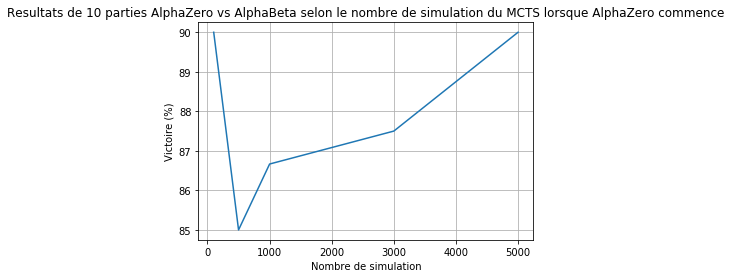

In [0]:
plt.plot(simu,victory_rate)
plt.title("Resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS lorsque AlphaZero commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

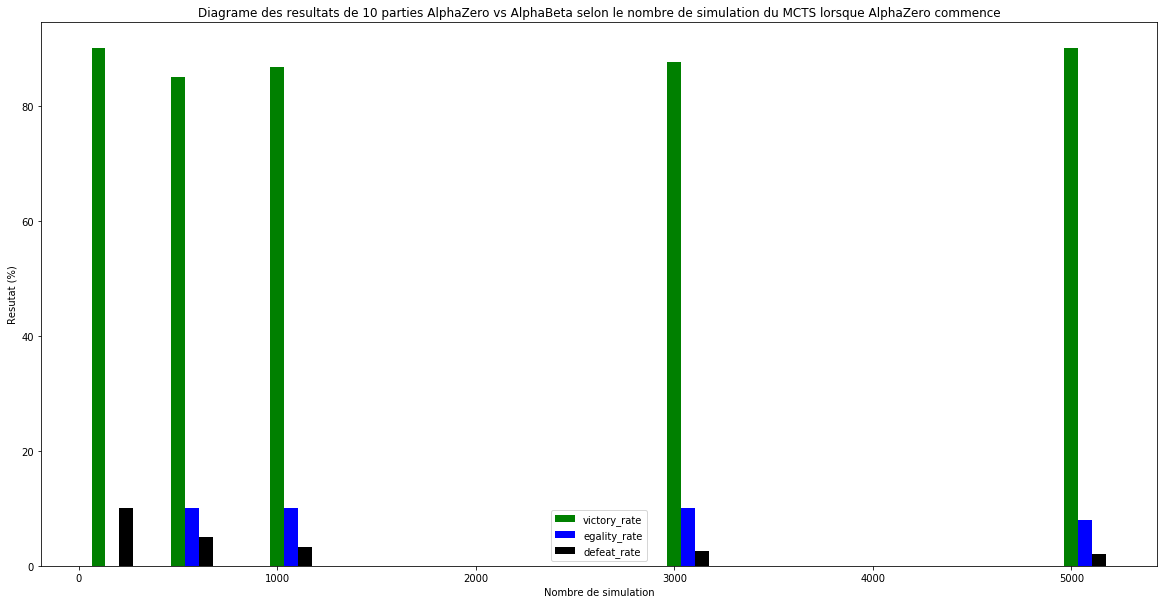

In [0]:

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS lorsque AlphaZero commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

#### AlphaBeta Commence

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:  
  print ("Nombre de simulations :", sim)
  compteur=0
  
  while compteur <nbre_simu:
    
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')

    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 3= Monte Carlo Tree Search, 4= Alpha Beta; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[4,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = 0
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False
    c_param=1.
    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur1 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur1 joue case:  [0, 0]
['O', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
joueur2 joue case:  [1 1]
['O', ' ', ' ']
[' ', 'X', ' ']
[' ', ' ', ' ']
=====> début du tour 2
joueur1 joue case:  [0, 1]
['O', 'O', ' ']
[' ', 'X', ' ']
[' ', ' ', ' ']
joueur2 joue case:  [0 2]
['O', 'O', 'X']joueur1 joue case:  
[1, 0][' ', 'X', ' ']

[' ', ' ', ' ']
=====> début du tour 3
['O', 'O', 'X']
['O', 'X', ' ']
[' ', ' ', ' ']
joueur2 joue case:  [2 0]
['O', 'O', 'X']
['O', 'X', ' ']
['X', ' ', ' ']
le gagnant est: joueur2 ('X')
fin du jeu
fin du thread joueur1
fin du thread joueur2
A bientôt pour un prochain jeu!
Partie 1
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur1 qui commence
[' ', ' '

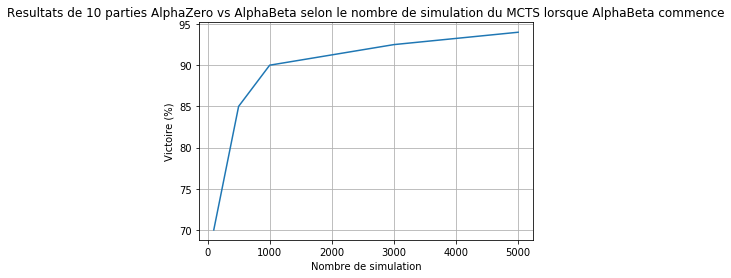

In [0]:
plt.plot(simu,victory_rate)
plt.title("Resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS lorsque AlphaBeta commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

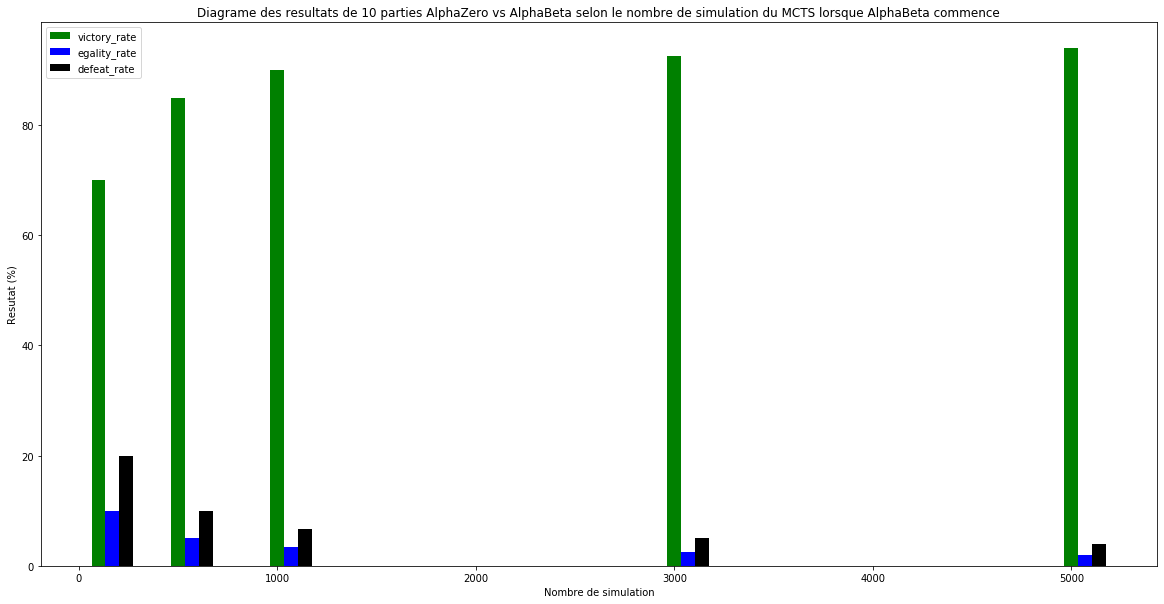

In [0]:

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs AlphaBeta selon le nombre de simulation du MCTS lorsque AlphaBeta commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

### AlphaZero VS Ordinateur

#### AlphaZero commence

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:
  print ("Nombre de simulations :", sim)
  compteur=0
  while compteur <nbre_simu:
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')
            
    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[0,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = 1
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False

    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  #print(nb_victoire)
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur2 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur2 joue case:  [1 0]
[' ', ' ', ' ']
['X', ' ', ' ']
[' ', ' ', ' ']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [1, 1]
[' ', ' ', ' ']
['X', 'O', ' ']
[' ', ' ', ' ']
=====> début du tour 2
joueur2 joue case:  [2 2]
[' ', ' ', ' ']
['X', 'O', ' ']
[' ', ' ', 'X']
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [0, 0]
['O', ' ', ' ']
['X', 'O', ' ']
[' ', ' ', 'X']
=====> début du tour 3
joueur2 joue case:  [0 2]
['O', ' ', 'X']joueur1 joue ('O' contre 'X')

['X', 'O', ' ']joueur1 joue case: 
 [' ', ' ', 'X'][2, 1]

['O', ' ', 'X']joueur2 joue case: 
['X', 'O', ' '] 
[1 2][' ', 'O', 'X']
=====> début du tour 4

['O', ' ', 'X']
['X', 'O', 'X']
[' ', 'O', 'X']
le gagnant est: joueur2 ('X')
fin du jeu
fin du thread joueur1
fin du thread jou

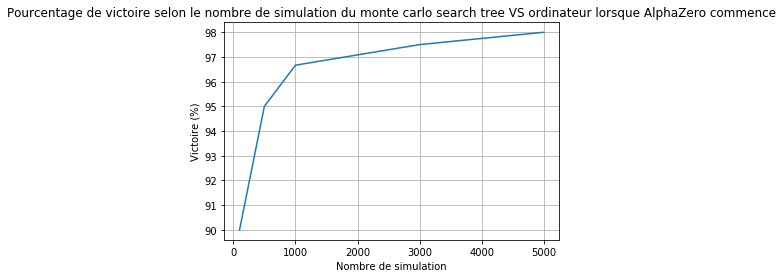

In [0]:
plt.plot(simu,victory_rate)
plt.title("Pourcentage de victoire selon le nombre de simulation du monte carlo search tree VS ordinateur lorsque AlphaZero commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

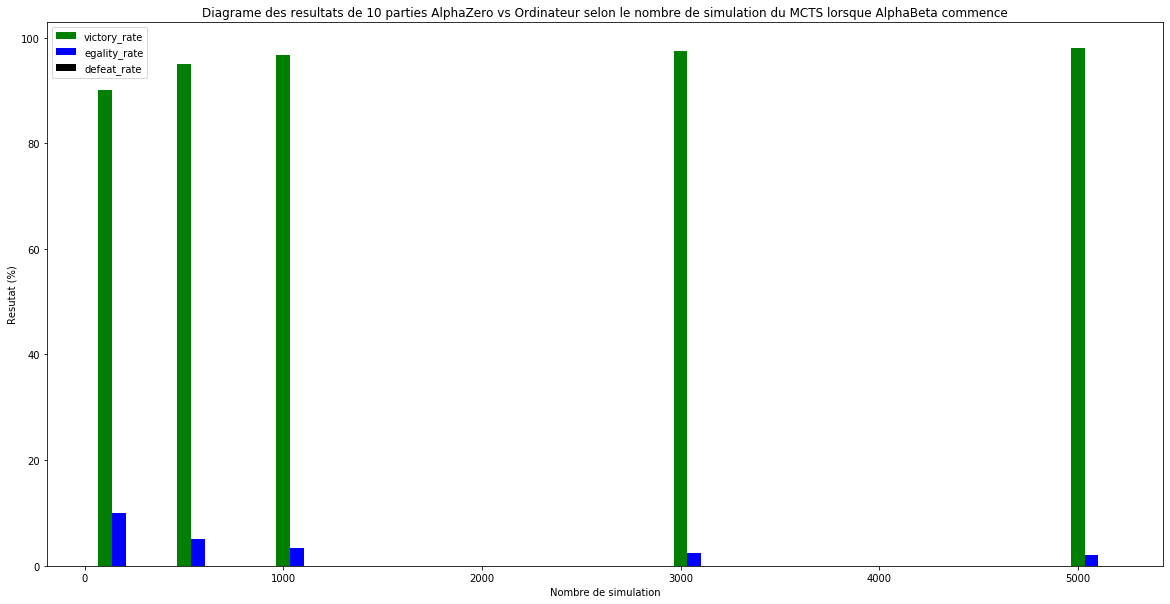

In [0]:

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs Ordinateur selon le nombre de simulation du MCTS lorsque AlphaBeta commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()

#### Ordinateur Commence

In [0]:

nb_victoire=[]
victory_rate=[]
egality_rate=[]
defeat_rate=[]
temps_moyen=[]
temp=[]
for sim in simu:
  print ("Nombre de simulations :", sim)
  compteur=0
  while compteur <nbre_simu:
    print ("Partie", compteur)
    start = time.clock()#temps
    ###############################################################################
    # Mise en place de la grille du jeu
    imax = 3
    jmax = 3
    grille=[]
    for i in range(0,imax):
        grille.append([])
        for j in range(0,jmax):
            grille[i].append(' ')
            
    print ("Bonjour! En route pour le jeu de morpion!")

    ############################## => initialisation du jeu et des conditions de son démarrage

    # nombre de joueurs
    nbjoueurs = 2

    # type de joueurs: 0=ordinateur, 1=humain; on doit avoir: len(typejoueurs)==nbjoueurs
    typejoueurs=[0,3]
    # savoir si une aide est demandée:
    aide=False

    # type de pion affecté à chaque joueur.
    pions = ['O','X']  # 
    print ("=====> le joueur1 a le pion 'O', et l'autre le pion 'X'")

    # définir celui qui commence, ou définir au hasard
    premier = 0
            

    print
    print ("=====> c'est joueur"+str(premier+1)+" qui commence")

    ############################## => initialisation du programme

    # création du verrou qui permettra le monopole d'accès aux variables globales (lecture-écriture)
    verrou = threading.Lock()

    # création du "compteur de coups" initialisé à -1 parce que c'est le programme principal qui commence
    cdcoups = -1

    # drapeau initialisé à True pour que le programme principal reprenne la main après chaque coup
    #   (initialisé à -1 parce que c'est le programme principal qui commence)
    okjoue = False

    # creation de la liste des joueurs (NB: le joueur numéro 0 est appelé "joueur1")
    joueurs = []
    for i in range(0,nbjoueurs):
        j = Joueur("joueur%d" % (i+1), i, pions[i], typejoueurs[i],sim,c_param=1.)
        j.setDaemon(True)
        joueurs.append(j)

    # lancement de tous les threads des joueurs
    for i in range(0,nbjoueurs):
        joueurs[i].start()

    ##############################
    # surveillance du jeu et attente condition de fin de partie

    tps=time.time()
    while True:
        # attente qu'un joueur ait joué
        while True:
            verrou.acquire() 
            if not okjoue:
                cdcoups+=1 #  on incrémente le compteur de coups du coup qui vient d'être joué
                # on sort de la boucle, mais le verrou reste bloqué pendant la surveillance
                break
            verrou.release()

        # affichage de la grille après le dernier coup
        print
        for i in range(0,imax):
            print(grille[i])


        # voir si un gagnant
        x = jeugagne()
        if x!="":
            end = time.clock()
            temp.append(end-start)
            if x==pions[0]:
                gagnant = "joueur1 ('" + pions[0] + "')"
                nb_victoire.append(str(pions[0]))
            else:
                gagnant = "joueur2 ('" + pions[1] + "')"
                nb_victoire.append(str(pions[1]))
            print
            print ("le gagnant est: " + gagnant)
            
            verrou.release()
            break

        # condition de fin de jeu
        if grillepleine():
            print
            print("pas de gagnant!")
            nb_victoire.append(str(None))
            verrou.release()
            break

        # détection du départ d'un nouveau tour numéro ((cdcoups//nbjoueurs)+1) par (cdcoups%nbjoueurs==0)
        ch=""
        if cdcoups%nbjoueurs==0:
            print
            print ("=====> début du tour " + str((cdcoups//nbjoueurs)+1))

        # permet au joueur suivant de jouer
        okjoue = True
        verrou.release()
        # et on boucle pour attendre jusqu'à ce que le joueur suivant ait joué

    #############################
    # fin du jeu
    print
    print ("fin du jeu")
    
    # arrêt de tous les threads
    for i in range(0,nbjoueurs):
        joueurs[i].stopper()

    # attente jusqu'à ce que tous les threads soient terminés
    for i in range(0,nbjoueurs):
        joueurs[i].join()
        verrou.acquire()
        print ("fin du thread " + joueurs[i].getName())
        verrou.release()

    print
    print ("A bientôt pour un prochain jeu!")
    compteur+=1
  #print(nb_victoire)
  victory_rate.append(nb_victoire.count('X')/len(nb_victoire)*100)
  egality_rate.append(nb_victoire.count('None')/len(nb_victoire)*100)
  defeat_rate.append(nb_victoire.count('O')/len(nb_victoire)*100)
  temps_moyen.append(np.mean(temp))
  


Nombre de simulations : 100
Partie 0
Bonjour! En route pour le jeu de morpion!
=====> le joueur1 a le pion 'O', et l'autre le pion 'X'
=====> c'est joueur1 qui commence
[' ', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', ' ']
=====> début du tour 1
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [1, 1]
[' ', ' ', ' ']
[' ', 'O', ' ']
[' ', ' ', ' ']
joueur2 joue case:  [2 0]
[' ', ' ', ' ']
[' ', 'O', ' ']
['X', ' ', ' ']
=====> début du tour 2
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [2, 2]
[' ', ' ', ' ']
[' ', 'O', ' ']
['X', ' ', 'O']
joueur2 joue case:  [0 0]
['X', ' ', ' ']
[' ', 'O', ' ']
['X', ' ', 'O']
=====> début du tour 3
joueur1 joue ('O' contre 'X')
joueur1 joue case:  [0, 2]
['X', ' ', 'O']
[' ', 'O', ' ']
['X', ' ', 'O']
joueur2 joue case:  [1 0]
['X', ' ', 'O']
['X', 'O', ' ']
['X', ' ', 'O']
le gagnant est: joueur2 ('X')
fin du jeu
fin du thread joueur1
fin du thread joueur2
A bientôt pour un prochain jeu!
Partie 1
Bonjour! En route pour le jeu de morpion!
=====> le

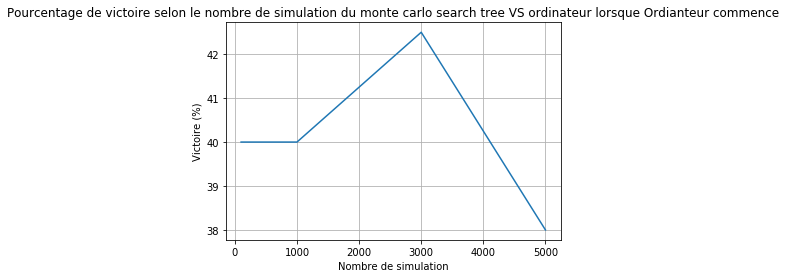

In [0]:
plt.plot(simu,victory_rate)
plt.title("Pourcentage de victoire selon le nombre de simulation du monte carlo search tree VS ordinateur lorsque Ordianteur commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Victoire (%)")
plt.grid()

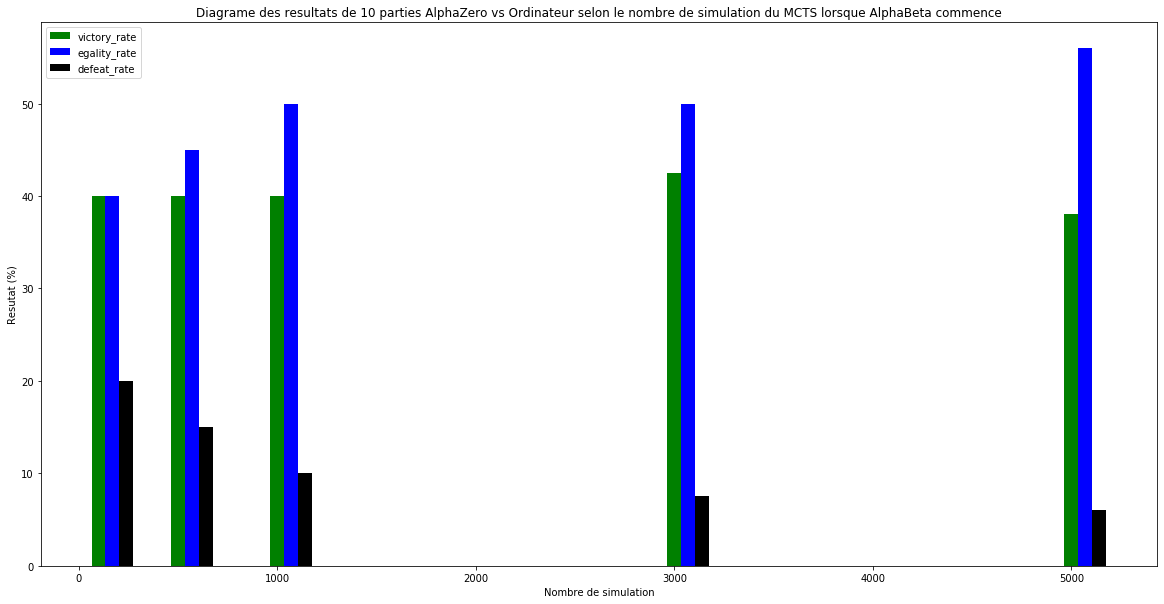

In [0]:

plt.figure(figsize=(20,10))

barWidth = 70
simu2 = [x + barWidth for x in simu]
simu3 = [x + barWidth for x in simu2]

plt.bar(simu,victory_rate, width = barWidth, color = ['green' for i in victory_rate], label='victory_rate')

plt.bar(simu2,egality_rate, width = barWidth, color = ['blue' for i in egality_rate],label='egality_rate')

plt.bar(simu3,defeat_rate, width = barWidth, color = ['black' for i in defeat_rate],label='defeat_rate')
plt.title("Diagrame des resultats de 10 parties AlphaZero vs Ordinateur selon le nombre de simulation du MCTS lorsque AlphaBeta commence")
plt.xlabel("Nombre de simulation")
plt.ylabel("Resutat (%)")
plt.legend()